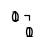

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import torch
from torch import nn
import torch.nn.functional as F
import glob
# Here you import other functions and classes
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import encode_batch, AA_KEYS, BL62_VALUES, BL62FREQ_VALUES, HLAS, BL50, BL50_VALUES
from src.models import NNAlignEFSinglePass
from src.datasets import NNAlignDatasetEFSinglePass

In [2]:
# Note : I always name my notebooks with the day's date, with YYMMDD_descriptor.ipynb, and data / output the same way


# Here, a sample data just so that you can try playing around with the functions (that will have different columns from what you might have at the end)
df = pd.read_csv('../data/mhc1_el_sub10k/mhc1_el_subsampled.csv')
df.head()

,sequence,target,HLA,pseudoseq,partition
0,ELLKHQRMHTGHL,0.0,HLA-A01:01,DRQELLGHLPFD,0
1,KKDINNIVKTL,0.0,HLA-B15:01,DIRKKDKTLHEW,0
2,QVNGEAGSYEM,0.0,H-2-Dq,RKSQVNYEMTNQ,0
3,DVGELVGLGDVM,0.0,H-2-Kb,CAVDVGDVMDAL,0
4,RENPVVPIGCL,0.0,HLA-B51:01,RKTRENGCLATA,0


In [3]:
# Here, you can define the length of each sequence
df['len'] = df['sequence'].apply(len)
max_len = 9
window_size = 9

In [4]:
# Here, we can use "-" as the insert, with put 0s (though it is not the most correct technically)
encode_batch(['GILGF-FTL'], max_len=9, encoding='BL50LO', pad_scale=-20)

tensor([[[ 0., -3.,  0., -1., -3., -2., -3.,  8., -2., -4., -4., -2., -3., -4.,
          -2.,  0., -2., -3., -3., -4.],
         [-1., -4., -3., -4., -2., -3., -4., -4., -4.,  5.,  2., -3.,  2.,  0.,
          -3., -3., -1., -3., -1.,  4.],
         [-2., -3., -4., -4., -2., -2., -3., -4., -3.,  2.,  5., -3.,  3.,  1.,
          -4., -3., -1., -2., -1.,  1.],
         [ 0., -3.,  0., -1., -3., -2., -3.,  8., -2., -4., -4., -2., -3., -4.,
          -2.,  0., -2., -3., -3., -4.],
         [-3., -3., -4., -5., -2., -4., -3., -4., -1.,  0.,  1., -4.,  0.,  8.,
          -4., -3., -2.,  1.,  4., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.],
         [-3., -3., -4., -5., -2., -4., -3., -4., -1.,  0.,  1., -4.,  0.,  8.,
          -4., -3., -2.,  1.,  4., -1.],
         [ 0., -1.,  0., -1., -1., -1., -1., -2., -2., -1., -1., -1., -1., -2.,
          -1.,  2.,  5., -3., -2.,  0.],
         [-2., -3., -4., -4., -2

In [36]:
from src.data_processing import encode_batch, encode

def do_insertion_deletion(sequence, max_len=13, encoding='BL50LO', pad_scale=-20, window_size=9):
    length = len(sequence)
    indel_windows = []

    # Insertion for sequences shorter than the window size
    if length < window_size:
        for i in range(window_size):
            indel_windows.append(sequence[:i] + '-' + sequence[i:])
        indel_windows.append('-'*9)    
    # Replicate sequence for sequences equal to the window size
    elif length == window_size:
        indel_windows.append(sequence)
        while len(indel_windows) < (window_size + 1):  
            indel_windows.append('-'*9) 
    # Deletion for sequences longer than the window size
    else:
        del_len = length - window_size
        for i in range(length - del_len + 1):
            indel_windows.append(sequence[:i] + sequence[i+del_len:])
            
    # Encoding the sequences
    encoded_sequences = encode_batch(indel_windows, max_len=max_len, encoding=encoding, pad_scale=pad_scale)
    print(indel_windows)
    return encoded_sequences
    
def batch_insertion_deletion(sequences, max_len=13, encoding='BL50LO', pad_scale=-20, window_size=9):
    # Process each sequence individually with do_insertion_deletion
    processed_sequences = [do_insertion_deletion(seq, max_len=max_len, encoding=encoding, pad_scale=pad_scale, window_size=window_size) for seq in sequences]
    
    # Stack the processed sequences along a new dimension to maintain the N x 9 x 13 x 20 structure
    # Ensure each do_insertion_deletion call returns a tensor of shape 9 x 13 x 20
    indel_windows_batch = torch.stack(processed_sequences)
    return indel_windows_batch
    
# Example usage:
sequences = ['GILGFVTL', 'GILGFVTLI', 'GILGFVTLIG', 'GILGFVTLIGF', 'GILGFVTLIGFT']
results = batch_insertion_deletion(sequences, max_len = 12)

print(results.shape)








['-GILGFVTL', 'G-ILGFVTL', 'GI-LGFVTL', 'GIL-GFVTL', 'GILG-FVTL', 'GILGF-VTL', 'GILGFV-TL', 'GILGFVT-L', 'GILGFVTL-', '---------']
['GILGFVTLI', '---------', '---------', '---------', '---------', '---------', '---------', '---------', '---------', '---------']
['ILGFVTLIG', 'GLGFVTLIG', 'GIGFVTLIG', 'GILFVTLIG', 'GILGVTLIG', 'GILGFTLIG', 'GILGFVLIG', 'GILGFVTIG', 'GILGFVTLG', 'GILGFVTLI']
['LGFVTLIGF', 'GGFVTLIGF', 'GIFVTLIGF', 'GILVTLIGF', 'GILGTLIGF', 'GILGFLIGF', 'GILGFVIGF', 'GILGFVTGF', 'GILGFVTLF', 'GILGFVTLI']
['GFVTLIGFT', 'GFVTLIGFT', 'GIVTLIGFT', 'GILTLIGFT', 'GILGLIGFT', 'GILGFIGFT', 'GILGFVGFT', 'GILGFVTFT', 'GILGFVTLT', 'GILGFVTLI']
torch.Size([5, 10, 12, 20])


In [37]:
results[2][9]




tensor([[  0.,  -3.,   0.,  -1.,  -3.,  -2.,  -3.,   8.,  -2.,  -4.,  -4.,  -2.,
          -3.,  -4.,  -2.,   0.,  -2.,  -3.,  -3.,  -4.],
        [ -1.,  -4.,  -3.,  -4.,  -2.,  -3.,  -4.,  -4.,  -4.,   5.,   2.,  -3.,
           2.,   0.,  -3.,  -3.,  -1.,  -3.,  -1.,   4.],
        [ -2.,  -3.,  -4.,  -4.,  -2.,  -2.,  -3.,  -4.,  -3.,   2.,   5.,  -3.,
           3.,   1.,  -4.,  -3.,  -1.,  -2.,  -1.,   1.],
        [  0.,  -3.,   0.,  -1.,  -3.,  -2.,  -3.,   8.,  -2.,  -4.,  -4.,  -2.,
          -3.,  -4.,  -2.,   0.,  -2.,  -3.,  -3.,  -4.],
        [ -3.,  -3.,  -4.,  -5.,  -2.,  -4.,  -3.,  -4.,  -1.,   0.,   1.,  -4.,
           0.,   8.,  -4.,  -3.,  -2.,   1.,   4.,  -1.],
        [  0.,  -3.,  -3.,  -4.,  -1.,  -3.,  -3.,  -4.,  -4.,   4.,   1.,  -3.,
           1.,  -1.,  -3.,  -2.,   0.,  -3.,  -1.,   5.],
        [  0.,  -1.,   0.,  -1.,  -1.,  -1.,  -1.,  -2.,  -2.,  -1.,  -1.,  -1.,
          -1.,  -2.,  -1.,   2.,   5.,  -3.,  -2.,   0.],
        [ -2.,  -3.,  -4., 